# NHANES Data Preprocessing
Notebook to pre-process NHANES data ready for SuStaIn.

## Important columns
- SEQN - Respondent sequence number or ID number (no duplicates)
- Both AUXU1K1R and AUXU1K2R* (Same for left ear)
- Relatedly, AUXR1K1R is a "retest" at 1kHz
- AUXU500R, AUXU2KR, AUXU4KR, AUXU8KR (Same for left ear)
- AUXU3KR, AUXU6KR (not common in UK)(Same for left ear)

*From the website:
As an additional quality measure, all audiograms, whether conducted in automated or manual mode, tested the 1000 Hz frequency twice in each ear as a measure of the reliability of the subject’s responses. Pure tone audiograms were not accepted if there was more than a 10 dB difference between them.
Therefore, if retest exsists then the retest should be retained in preference to the original test.

## Import modules and define functions

In [1]:
# import modules
import os
import warnings

import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Change dir to NHANES data
os.chdir('../data')

# Set plotting params
sns.set(rc={"figure.figsize":(15 , 9 )})
sns.set(font_scale=1.5, style="whitegrid")

In [3]:
def load_and_filter_cohort(common_fhand_suffix='1999-2000.csv'):
    """Load NHANES cohort data and filter auxiliary and demographic information.

    Args:
        common_fhand_suffix (str): Common filename suffix for NHANES data files. Default is '1999-2000.csv'.

    Returns:
        tuple: A tuple containing four DataFrames:
            - nhanes_demo_df: DataFrame containing demographic data.
            - filtered_nhanes_aux_df: DataFrame containing filtered auxiliary data.
            - nhanes_auxr_df: DataFrame containing auxiliary reflex data.
            - nhanes_auxt_df: DataFrame containing auxiliary tympanometry data.
    """

    try:
        # Load NHANES data
        nhanes_demo_df = pd.read_csv(f'./demo/nhanes_demo_{common_fhand_suffix}')
        nhanes_aux_df = pd.read_csv(f'./pta/nhanes_aux_{common_fhand_suffix}')
        nhanes_auxr_df = pd.read_csv(f'./reflex/nhanes_auxr_{common_fhand_suffix}')
        nhanes_auxt_df = pd.read_csv(f'./tymp/nhanes_auxt_{common_fhand_suffix}')

    except FileNotFoundError:
        print('Could not find data, please double check that your cwd is where the data is stored.')
        return

    # Filter auxiliary data
    filtered_nhanes_aux_df = filter_aux_df(nhanes_aux_df)

    # Filter demographic data
    filtered_nhanes_demo_df = filter_demo_df(nhanes_demo_df, filtered_nhanes_aux_df)

    return filtered_nhanes_demo_df, filtered_nhanes_aux_df, nhanes_auxr_df, nhanes_auxt_df


def filter_aux_df(nhanes_aux_df):
    """Filter auxiliary data.

    Args:
        nhanes_aux_df (DataFrame): DataFrame containing NHANES auxiliary data.

    Returns:
        DataFrame: Filtered DataFrame containing selected columns and replaced error codes with NaNs.
    """
    # Select relevant columns
    subset_col_names = ['SEQN', 'AUXU1K1R', 'AUXU500R', 'AUXU1K2R', 'AUXU2KR', 'AUXU3KR', 'AUXU4KR', 'AUXU6KR',
                        'AUXU8KR', 'AUXU1K1L', 'AUXU500L', 'AUXU1K2L', 'AUXU2KL', 'AUXU3KL', 'AUXU4KL', 'AUXU6KL',
                        'AUXU8KL']
    filtered_nhanes_aux_df = nhanes_aux_df[subset_col_names]

    # Replace error codes with NaNs
    filtered_nhanes_aux_df = filtered_nhanes_aux_df.replace({888: np.NaN, 666: np.NaN})

    return filtered_nhanes_aux_df


def filter_demo_df(nhanes_demo_df, nhanes_aux_df):
    """Filter demographic data.

    Args:
        nhanes_demo_df (DataFrame): DataFrame containing NHANES demographic data.
        nhanes_aux_df (DataFrame): DataFrame containing filtered NHANES auxiliary data.

    Returns:
        DataFrame: Filtered DataFrame containing selected demographic columns.
    """
    # Select relevant columns
    subset_col_names = ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN', 'RIDRETH1']

    # Filter demographic data
    filtered_demo_df = nhanes_demo_df[subset_col_names]

    # Match patients in demographic data to patients in auxiliary data
    filtered_demo_df = filtered_demo_df[filtered_demo_df.SEQN.isin(nhanes_aux_df.SEQN)]
    filtered_demo_df.reset_index(inplace=True, drop=True)

    return filtered_demo_df




## Extract NHANES data across all cohorts

In [4]:
import pandas as pd
import numpy as np

def load_and_filter_cohort(common_fhand_suffix='1999-2000.csv'):
    """Load NHANES cohort data and filter auxiliary and demographic information.

    Args:
        common_fhand_suffix (str): Common filename suffix for NHANES data files. Default is '1999-2000.csv'.

    Returns:
        DataFrame: A DataFrame containing filtered cohort data.
    """

    try:
        # Load NHANES data
        nhanes_demo_df = pd.read_csv(f'./demo/nhanes_demo_{common_fhand_suffix}')
        nhanes_aux_df = pd.read_csv(f'./pta/nhanes_aux_{common_fhand_suffix}')
        nhanes_auxr_df = pd.read_csv(f'./reflex/nhanes_auxr_{common_fhand_suffix}')
        nhanes_auxt_df = pd.read_csv(f'./tymp/nhanes_auxt_{common_fhand_suffix}')

    except FileNotFoundError:
        print('Could not find data, please double check that your cwd is where the data is stored.')
        return

    # Filter auxiliary data
    filtered_nhanes_aux_df = filter_aux_df(nhanes_aux_df)

    # Filter demographic data
    filtered_demo_df = filter_demo_df(nhanes_demo_df, filtered_nhanes_aux_df)

    # Combine filtered data
    cohort_df = pd.concat([filtered_demo_df,
                           filtered_nhanes_aux_df.iloc[:, 1:]], axis=1)

    # Add cohort identifier
    cohort = common_fhand_suffix[:-4]
    cohort_df['Cohort'] = np.full(cohort_df.shape[0], cohort)
    cohort_df.reset_index(inplace=True, drop=True)

    # Create tidy columns
    cohort_df['Age (years)'] = cohort_df['RIDAGEYR']
    cohort_df['Gender'] = cohort_df['RIAGENDR'].replace({1.0: 'Male', 2.0: 'Female'})
    cohort_df['Race/ethnicity'] = cohort_df['RIDRETH1'].replace({1.0: 'Mexican American',
                                                                 2.0: 'Other Hispanic',
                                                                 3.0: 'Non-Hispanic White',
                                                                 4.0: 'Non-Hispanic Black',
                                                                 5.0: 'Other Race - Including Multi-Racial'})

    return cohort_df


def filter_aux_df(nhanes_aux_df):
    """Filter auxiliary data.

    Args:
        nhanes_aux_df (DataFrame): DataFrame containing NHANES auxiliary data.

    Returns:
        DataFrame: Filtered DataFrame containing selected columns and replaced error codes with NaNs.
    """
    # Select relevant columns
    subset_col_names = ['SEQN', 'AUXU1K1R', 'AUXU500R', 'AUXU1K2R', 'AUXU2KR', 'AUXU3KR', 'AUXU4KR', 'AUXU6KR',
                        'AUXU8KR', 'AUXU1K1L', 'AUXU500L', 'AUXU1K2L', 'AUXU2KL', 'AUXU3KL', 'AUXU4KL', 'AUXU6KL',
                        'AUXU8KL']
    filtered_nhanes_aux_df = nhanes_aux_df[subset_col_names]

    # Replace error codes with NaNs
    filtered_nhanes_aux_df = filtered_nhanes_aux_df.replace({888: np.NaN, 666: np.NaN})

    return filtered_nhanes_aux_df


def filter_demo_df(nhanes_demo_df, nhanes_aux_df):
    """Filter demographic data.

    Args:
        nhanes_demo_df (DataFrame): DataFrame containing NHANES demographic data.
        nhanes_aux_df (DataFrame): DataFrame containing filtered NHANES auxiliary data.

    Returns:
        DataFrame: Filtered DataFrame containing selected demographic columns.
    """
    # Select relevant columns
    subset_col_names = ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN', 'RIDRETH1']

    # Filter demographic data
    filtered_demo_df = nhanes_demo_df[subset_col_names]

    # Match patients in demographic data to patients in auxiliary data
    filtered_demo_df = filtered_demo_df[filtered_demo_df.SEQN.isin(nhanes_aux_df.SEQN)]
    filtered_demo_df.reset_index(inplace=True, drop=True)

    return filtered_demo_df


# Combine all NHANES data
common_fhand_suffixes = ['1999-2000.csv', '2001-02.csv', '2003-04.csv', '2005-06.csv', '2007-08.csv',
                         '2009-10.csv', '2011-12.csv', '2015-16.csv', '2017-18.csv', '2017-20.csv']

# Initialize an empty DataFrame to hold the combined data
nhanes_df = pd.DataFrame()

# Cycle through cohorts
for cohort_fhand in common_fhand_suffixes:
    # Load and filter cohort data
    cohort_data = load_and_filter_cohort(common_fhand_suffix=cohort_fhand)

    # Concatenate cohort data
    nhanes_df = pd.concat([nhanes_df, cohort_data], axis=0, ignore_index=True)

# Reset index of the final dataframe
nhanes_df.reset_index(drop=True, inplace=True)


In [5]:
nhanes_df


,SEQN,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,AUXU1K1R,AUXU500R,AUXU1K2R,AUXU2KR,AUXU3KR,...,AUXU1K2L,AUXU2KL,AUXU3KL,AUXU4KL,AUXU6KL,AUXU8KL,Cohort,Age (years),Gender,Race/ethnicity
0,10.0,1.0,43.0,518.0,4.0,5.0,10.0,5.0,10.0,10.0,...,10.0,20.0,10.0,10.0,20.0,15.0,1999-2000,43.0,Male,Non-Hispanic Black
1,15.0,2.0,38.0,459.0,3.0,-5.0,0.0,0.0,-5.0,0.0,...,10.0,5.0,10.0,5.0,10.0,5.0,1999-2000,38.0,Female,Non-Hispanic White
2,24.0,2.0,53.0,644.0,3.0,15.0,10.0,15.0,15.0,10.0,...,15.0,20.0,15.0,25.0,15.0,15.0,1999-2000,53.0,Female,Non-Hispanic White
3,45.0,2.0,33.0,405.0,1.0,0.0,5.0,0.0,0.0,10.0,...,-5.0,-5.0,5.0,10.0,15.0,0.0,1999-2000,33.0,Female,Mexican American
4,56.0,1.0,21.0,261.0,3.0,20.0,5.0,15.0,35.0,30.0,...,20.0,40.0,45.0,30.0,15.0,15.0,1999-2000,21.0,Male,Non-Hispanic White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29709,124797.0,1.0,9.0,NaN,1.0,5.0,NaN,0.0,5.0,NaN,...,0.0,-5.0,NaN,5.0,NaN,10.0,2017-20,9.0,Male,Mexican American
29710,124799.0,2.0,80.0,NaN,3.0,30.0,25.0,35.0,40.0,35.0,...,40.0,45.0,45.0,60.0,85.0,NaN,2017-20,80.0,Female,Non-Hispanic White
29711,124811.0,1.0,76.0,NaN,3.0,20.0,30.0,20.0,5.0,25.0,...,35.0,15.0,30.0,25.0,55.0,60.0,2017-20,76.0,Male,Non-Hispanic White
29712,124820.0,2.0,7.0,NaN,3.0,5.0,NaN,10.0,5.0,NaN,...,10.0,10.0,NaN,10.0,NaN,15.0,2017-20,7.0,Female,Non-Hispanic White


### Create NHANES subsets for later use

In [6]:
# rename and re-order pta data
subset_aux_col_names = ['AUXU1K1R',
                    'AUXU500R',
                    'AUXU2KR',
                    'AUXU4KR',
                    'AUXU8KR',
                    'AUXU1K1L',
                    'AUXU500L',
                    'AUXU2KL',
                    'AUXU4KL',
                    'AUXU8KL'] 
nhanes_pta = nhanes_df[subset_aux_col_names]

## relabel columns for visualisation
nhanes_pta.columns = ['1kHz Right',
                           '0.5kHz Right',
                           '2kHz Right',
                           '4kHz Right',
                           '8kHz Right',
                           '1kHz Left',
                           '0.5kHz Left',
                           '2kHz Left',
                           '4kHz Left',
                           '8kHz Left']
## reorder columns
ordered_nhanes_pta = nhanes_pta[['0.5kHz Right',
                                           '0.5kHz Left',
                                          '1kHz Right',
                                          '1kHz Left',
                                          '2kHz Right',
                                          '2kHz Left',
                                          '4kHz Right',
                                          '4kHz Left',
                                          '8kHz Right',
                                          '8kHz Left'
                                          ]]

# Filter main NHANES df to include only demographics and PTA
nhanes_demo_pta_df = pd.concat([
    nhanes_df.SEQN.to_frame(),
    ordered_nhanes_pta,
    nhanes_df.Gender.to_frame(),
    nhanes_df['Age (years)'].to_frame(),
    nhanes_df['Race/ethnicity'].to_frame(),
], axis=1)

# create df for correlation analysis
nhanes_demo_pta_for_corr = pd.concat([
    ordered_nhanes_pta,
    nhanes_df.RIAGENDR.to_frame(),
    nhanes_df['Age (years)'].to_frame(),
    nhanes_df.RIDRETH1.to_frame(),
], axis=1)

# create hearing loss data subset
nhanes_pta_hearingLoss = nhanes_demo_pta_df.iloc[:, 1:-3] > 25
nhanes_pta_hearingLoss_desc = nhanes_pta_hearingLoss.iloc[:2, :]
for column_i in range(nhanes_pta_hearingLoss.shape[1]):
    column_i_HL_true = nhanes_pta_hearingLoss.iloc[:, column_i].sum()
    column_i_HL_false = nhanes_pta_hearingLoss.shape[0] - column_i_HL_true
    nhanes_pta_hearingLoss_desc.iloc[:, column_i] = np.array([column_i_HL_true, column_i_HL_false])

nhanes_pta_hearingLoss_desc.index= ['Hearing Loss', 'Normal Hearing']

# Aggregate left and right ear HL measures
## Extract only the frequency-related columns
frequency_columns = ['0.5kHz', '1kHz', '2kHz', '4kHz', '8kHz']

## Aggregate 'Right' and 'Left' columns for each frequency
aggregated_df = pd.DataFrame()
for freq_column in frequency_columns:
    right_column = f'{freq_column} Right'
    left_column = f'{freq_column} Left'
    aggregated_df[freq_column] = (nhanes_demo_pta_for_corr[right_column] + nhanes_demo_pta_for_corr[left_column]) / 2

non_frequency_columns = ['RIAGENDR', 'Age (years)', 'RIDRETH1']
for col in non_frequency_columns:
    aggregated_df[col] = nhanes_demo_pta_for_corr[col]

# Long Dataframe with ear coding
nhanes_pta_ear = pd.DataFrame({
    '0.5 kHz': np.concatenate([ordered_nhanes_pta['0.5kHz Right'].to_numpy(),
                               ordered_nhanes_pta['0.5kHz Left'].to_numpy()], axis=0),
    '1 kHz': np.concatenate([ordered_nhanes_pta['1kHz Right'].to_numpy(),
                               ordered_nhanes_pta['1kHz Left'].to_numpy()], axis=0),
    '2 kHz': np.concatenate([ordered_nhanes_pta['2kHz Right'].to_numpy(),
                               ordered_nhanes_pta['2kHz Left'].to_numpy()], axis=0),
    '4 kHz': np.concatenate([ordered_nhanes_pta['4kHz Right'].to_numpy(),
                               ordered_nhanes_pta['4kHz Left'].to_numpy()], axis=0),
    '8 kHz': np.concatenate([ordered_nhanes_pta['8kHz Right'].to_numpy(),
                               ordered_nhanes_pta['8kHz Left'].to_numpy()], axis=0),
    'Ear': np.concatenate([np.full(ordered_nhanes_pta.shape[0], 'Right'),
                           np.full(ordered_nhanes_pta.shape[0], 'Left')], axis=0)
})

# Create an empty Pandas DataFrame for storing processed PTA (Pure Tone Audiometry) data
nhanes_demo_pta_long_df = pd.DataFrame()

# Iterate over columns in the original dataset (nhanes_pta)
for i in ordered_nhanes_pta.columns:   
    # skip non-pta columns:
     
    # Extract the frequency information from the column name
    for j in range(9):
        if i.split(' ')[0][0] == str(j):
            if j == 0:
                frequency = 500
            else:
                frequency = j * 1000
        if i.split(' ')[1] == 'Right':
            ear = 'Right'
        elif i.split(' ')[1] == 'Left':
            ear='Left'
    
    # Extract hearing threshold values for the specific ear and frequency
    pta_values = nhanes_demo_pta_df[i].to_frame()
    nhanes_demo_pta_long_i = nhanes_demo_pta_df.SEQN.to_frame()
    nhanes_demo_pta_long_i['Hearing Threshold (dB HL)'] = pta_values.copy()
    nhanes_demo_pta_long_i['Frequency (Hz)'] = np.full((nhanes_pta.shape[0], 1), frequency)
    nhanes_demo_pta_long_i['Ear'] = np.full((nhanes_pta.shape[0], 1), ear)
    nhanes_demo_pta_long_i['Gender'] = nhanes_demo_pta_df.Gender
    nhanes_demo_pta_long_i['Age (years)'] = nhanes_demo_pta_df['Age (years)']
    nhanes_demo_pta_long_i['Race/ethnicity'] = nhanes_demo_pta_df['Race/ethnicity']

    # Append the processed data to the ear_nhanes_pta DataFrame
    if nhanes_demo_pta_long_df.empty:
        nhanes_demo_pta_long_df = nhanes_demo_pta_long_i
    else:
        # Concatenate DataFrames based on frequency, prioritizing 500 Hz data
        if frequency == 500:
            nhanes_demo_pta_long_df = pd.concat([nhanes_demo_pta_long_i, nhanes_demo_pta_long_df], axis=0)
        else:
            nhanes_demo_pta_long_df = pd.concat([nhanes_demo_pta_long_df, nhanes_demo_pta_long_i], axis=0)

# Replace infinite values with NaN and reset the index of the resulting DataFrame
nhanes_demo_pta_long_df.replace([np.inf, -np.inf], np.nan, inplace=True)
nhanes_demo_pta_long_df.reset_index(inplace=True, drop=True)

# Remove rows corresponding to 3000 and 6000 Hz frequencies
nhanes_demo_pta_long_df = nhanes_demo_pta_long_df[~nhanes_demo_pta_long_df['Frequency (Hz)'].isin([3000, 6000])]

# Create an empty Pandas DataFrame for storing processed PTA (Pure Tone Audiometry) data
ear_nhanes_pta = pd.DataFrame()

# Iterate over columns in the original dataset (nhanes_pta)
for i in nhanes_pta.columns:
    # Determine whether the ear is Right or Left based on column names
    if i.endswith('Right'):
        ear = 'Right'
    elif i.endswith('Left'):
        ear = 'Left'
    else:
        # Skip columns that do not represent Right or Left ear data
        continue
    
    # Extract the frequency information from the column name
    for j in range(9):
        if i.split(' ')[0][0] == str(j):
            if j == 0:
                frequency = 500
            else:
                frequency = j * 1000
    
    # Extract hearing threshold values for the specific ear and frequency
    pta_values = nhanes_pta[i].to_frame()
    ear_nhanes_pta_i = pta_values.copy()
    ear_nhanes_pta_i.columns = ['Hearing Threshold (dB HL)']
    ear_nhanes_pta_i['Ear'] = np.full((nhanes_pta.shape[0], 1), ear)
    ear_nhanes_pta_i['Frequency (Hz)'] = np.full((nhanes_pta.shape[0], 1), frequency)

    # Append the processed data to the ear_nhanes_pta DataFrame
    if ear_nhanes_pta.empty:
        ear_nhanes_pta = ear_nhanes_pta_i
    else:
        # Concatenate DataFrames based on frequency, prioritizing 500 Hz data
        if frequency == 500:
            ear_nhanes_pta = pd.concat([ear_nhanes_pta_i, ear_nhanes_pta], axis=0)
        else:
            ear_nhanes_pta = pd.concat([ear_nhanes_pta, ear_nhanes_pta_i], axis=0)

# Replace infinite values with NaN and reset the index of the resulting DataFrame
ear_nhanes_pta.replace([np.inf, -np.inf], np.nan, inplace=True)
ear_nhanes_pta.reset_index(inplace=True, drop=True)

# Remove rows corresponding to 3000 and 6000 Hz frequencies
ear_nhanes_pta = ear_nhanes_pta[~ear_nhanes_pta['Frequency (Hz)'].isin([3000, 6000])]

# create dataset with hearing loss coding
nhanes_demo_pta_HL_df = nhanes_demo_pta_df
n_people_with_HL = 0
idx_of_HL = []
for idx, row in nhanes_pta_hearingLoss.iterrows():
    if sum(row) > 0:
        n_people_with_HL+=1
        idx_of_HL.append(1)
    else:
        idx_of_HL.append(0)

nhanes_demo_pta_HL_df['Hearing Loss'] = idx_of_HL

# get just pta data of ppl with hearing loss
nhanes_HL = nhanes_demo_pta_HL_df[nhanes_demo_pta_HL_df['Hearing Loss'] == 1]
nhanes_HL.reset_index(inplace=True, drop=True)
nhanes_pta_HL = nhanes_HL.drop(['Gender', 'Age (years)', 'Race/ethnicity', 'SEQN', 'Hearing Loss'], axis=1, inplace=False)

# Create an empty Pandas DataFrame for storing processed PTA (Pure Tone Audiometry) data for just hearing loss
nhanes_demo_pta_HL_long_df = pd.DataFrame()

# Iterate over columns in the original dataset (nhanes_pta)
for i in nhanes_pta_HL.columns:   
    # Extract the frequency information from the column name
    for j in range(9):
        if i.split(' ')[0][0] == str(j):
            if j == 0:
                frequency = 500
            else:
                frequency = j * 1000
        if i.split(' ')[1] == 'Right':
            ear = 'Right'
        elif i.split(' ')[1] == 'Left':
            ear='Left'
    
    # Extract hearing threshold values for the specific ear and frequency
    pta_values = nhanes_pta_HL[i].to_frame()
    nhanes_demo_pta_long_i = nhanes_HL.SEQN.to_frame()
    nhanes_demo_pta_long_i['Hearing Threshold (dB HL)'] = pta_values.copy()
    nhanes_demo_pta_long_i['Frequency (Hz)'] = np.full((nhanes_HL.shape[0], 1), frequency)
    nhanes_demo_pta_long_i['Ear'] = np.full((nhanes_HL.shape[0], 1), ear)
    nhanes_demo_pta_long_i['Gender'] = nhanes_HL.Gender
    nhanes_demo_pta_long_i['Age (years)'] = nhanes_HL['Age (years)']
    nhanes_demo_pta_long_i['Race/ethnicity'] = nhanes_HL['Race/ethnicity']

    # Append the processed data to the ear_nhanes_pta DataFrame
    if nhanes_demo_pta_HL_long_df.empty:
        nhanes_demo_pta_HL_long_df = nhanes_demo_pta_long_i
    else:
        # Concatenate DataFrames based on frequency, prioritizing 500 Hz data
        if frequency == 500:
            nhanes_demo_pta_HL_long_df = pd.concat([nhanes_demo_pta_long_i, nhanes_demo_pta_HL_long_df], axis=0)
        else:
            nhanes_demo_pta_HL_long_df = pd.concat([nhanes_demo_pta_HL_long_df, nhanes_demo_pta_long_i], axis=0)

# Replace infinite values with NaN and reset the index of the resulting DataFrame
nhanes_demo_pta_HL_long_df.replace([np.inf, -np.inf], np.nan, inplace=True)
nhanes_demo_pta_HL_long_df.reset_index(inplace=True, drop=True)

# Remove rows corresponding to 3000 and 6000 Hz frequencies
nhanes_demo_pta_HL_long_df = nhanes_demo_pta_HL_long_df[~nhanes_demo_pta_HL_long_df['Frequency (Hz)'].isin([3000, 6000])]

# get just pta data of ppl with normal hearing
nhanes_HN = nhanes_demo_pta_HL_df[nhanes_demo_pta_HL_df['Hearing Loss'] == 0]
nhanes_HN.reset_index(inplace=True, drop=True)
nhanes_pta_HN = nhanes_HN.drop(['Gender', 'Age (years)', 'Race/ethnicity', 'SEQN', 'Hearing Loss'], axis=1, inplace=False)

# Create an empty Pandas DataFrame for storing processed PTA (Pure Tone Audiometry) data for just normal hearing
nhanes_demo_pta_HN_long_df = pd.DataFrame()

# Iterate over columns in the original dataset (nhanes_pta)
for i in nhanes_pta_HN.columns:   
    # Extract the frequency information from the column name
    for j in range(9):
        if i.split(' ')[0][0] == str(j):
            if j == 0:
                frequency = 500
            else:
                frequency = j * 1000
        if i.split(' ')[1] == 'Right':
            ear = 'Right'
        elif i.split(' ')[1] == 'Left':
            ear='Left'
    
    # Extract hearing threshold values for the specific ear and frequency
    pta_values = nhanes_pta_HN[i].to_frame()
    nhanes_demo_pta_long_i = nhanes_HN.SEQN.to_frame()
    nhanes_demo_pta_long_i['Hearing Threshold (dB HL)'] = pta_values.copy()
    nhanes_demo_pta_long_i['Frequency (Hz)'] = np.full((nhanes_HN.shape[0], 1), frequency)
    nhanes_demo_pta_long_i['Ear'] = np.full((nhanes_HN.shape[0], 1), ear)
    nhanes_demo_pta_long_i['Gender'] = nhanes_HN.Gender
    nhanes_demo_pta_long_i['Age (years)'] = nhanes_HN['Age (years)']
    nhanes_demo_pta_long_i['Race/ethnicity'] = nhanes_HN['Race/ethnicity']

    # Append the processed data to the ear_nhanes_pta DataFrame
    if nhanes_demo_pta_HN_long_df.empty:
        nhanes_demo_pta_HN_long_df = nhanes_demo_pta_long_i
    else:
        # Concatenate DataFrames based on frequency, prioritizing 500 Hz data
        if frequency == 500:
            nhanes_demo_pta_HN_long_df = pd.concat([nhanes_demo_pta_long_i, nhanes_demo_pta_HN_long_df], axis=0)
        else:
            nhanes_demo_pta_HN_long_df = pd.concat([nhanes_demo_pta_HN_long_df, nhanes_demo_pta_long_i], axis=0)

# Replace infinite values with NaN and reset the index of the resulting DataFrame
nhanes_demo_pta_HN_long_df.replace([np.inf, -np.inf], np.nan, inplace=True)
nhanes_demo_pta_HN_long_df.reset_index(inplace=True, drop=True)

# Remove rows corresponding to 3000 and 6000 Hz frequencies
nhanes_demo_pta_HN_long_df = nhanes_demo_pta_HN_long_df[~nhanes_demo_pta_HN_long_df['Frequency (Hz)'].isin([3000, 6000])]

In [43]:
nhanes_demo_pta_HL_df.to_csv('nhanes_1999to2020_demo_pta_hearingLoss.csv', index=False)

## Exploratory analysis

### Descriptives

#### Age and Gender

In [7]:
print('The mean age and standard deviation (years) of the NHANES cohort is {0:.2f} and {1:.2f}, respectively.'.format(nhanes_df.RIDAGEYR.mean(), nhanes_df.RIDAGEYR.std()))
print('The dataset has a range of {0} years and {1} months to {2} and {3} months'.format(divmod(nhanes_df.RIDAGEMN.min(), 12)[0],
                                                                                  divmod(nhanes_df.RIDAGEMN.min(), 12)[1],
                                                                                  divmod(nhanes_df.RIDAGEMN.max(), 12)[0],
                                                                                  divmod(nhanes_df.RIDAGEMN.max(), 12)[1]))

The mean age and standard deviation (years) of the NHANES cohort is 37.76 and 23.54, respectively.
The dataset has a range of 12.0 years and 0.0 months to 84.0 and 11.0 months


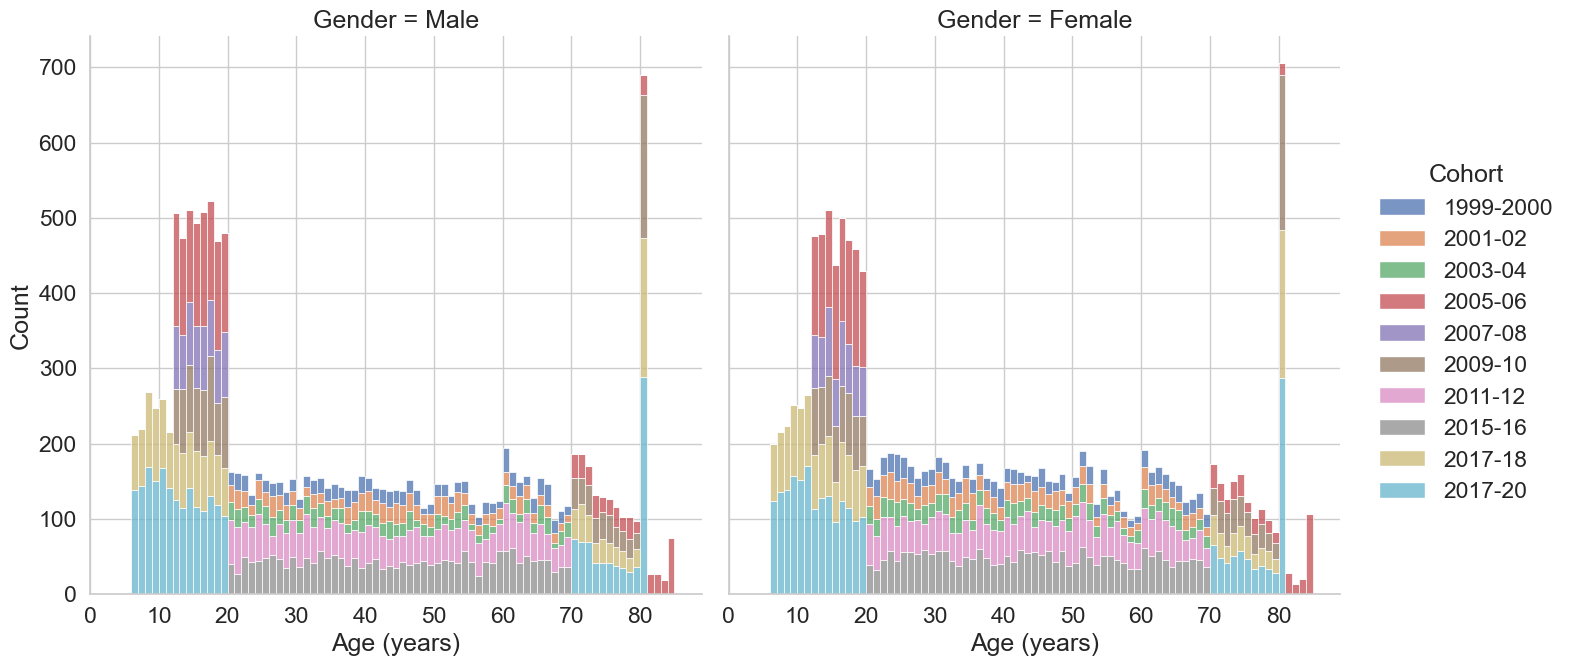

In [8]:
sns.displot(nhanes_df, x="Age (years)", hue="Cohort", col="Gender", multiple="stack",
            height=7,
            binwidth=1)
plt.xticks(np.arange(0, 90, 10))
plt.grid(visible=True, which='both')
plt.savefig('../figures/histogram_of_age_splitBy_genderCohort_nhanes.png', dpi=300,  bbox_inches="tight")

In [8]:
n_males = 0; n_females = 0

for idx, row in nhanes_df.iterrows():
    if row.Gender == 'Male':
        n_males += 1
    elif row.Gender == 'Female':
        n_females += 1
    else:
        pass
print('Number of males = {0}, number of females = {1}'.format(n_males, n_females))

Number of males = 14647, number of females = 15067


In [9]:
nhanes_df['Race/ethnicity'].value_counts()

Race/ethnicity
Non-Hispanic White                     11301
Non-Hispanic Black                      7017
Mexican American                        5342
Other Race - Including Multi-Racial     3532
Other Hispanic                          2522
Name: count, dtype: int64

#### Hearing loss

In [17]:
nhanes_pta_hearingLoss_desc

,0.5kHz Right,0.5kHz Left,1kHz Right,1kHz Left,2kHz Right,2kHz Left,4kHz Right,4kHz Left,8kHz Right,8kHz Left
Hearing Loss,2440,2282,2648,2611,3822,4057,6446,6945,8242,8401
Normal Hearing,27274,27432,27066,27103,25892,25657,23268,22769,21472,21313


In [10]:
# total number of people with hearing loss
n_people_with_HL = 0
idx_of_HL = []
for idx, row in nhanes_pta_hearingLoss.iterrows():
    if sum(row) > 0:
        n_people_with_HL+=1
        idx_of_HL.append(1)
    else:
        idx_of_HL.append(0)
print(f'Total number of people with hearing loss = {n_people_with_HL}\nTotal number of people in NHANES = {nhanes_pta_hearingLoss.shape[0]}\nPercetage of people in NHANES with hearaing loss = {(n_people_with_HL/nhanes_pta_hearingLoss.shape[0])*100}')

Total number of people with hearing loss = 11607
Total number of people in NHANES = 29714
Percetage of people in NHANES with hearaing loss = 39.062394830719526


## Graphical EDA of PTA data

### Distributions

#### Distributions of thresholds across pure tones, split by ear

In [25]:
# Display the processed PTA DataFrame
ear_nhanes_pta

,Hearing Threshold (dB HL),Ear,Frequency (Hz)
0,10.0,Left,500
1,0.0,Left,500
2,10.0,Left,500
3,0.0,Left,500
4,10.0,Left,500
...,...,...,...
297135,10.0,Left,8000
297136,NaN,Left,8000
297137,60.0,Left,8000
297138,15.0,Left,8000


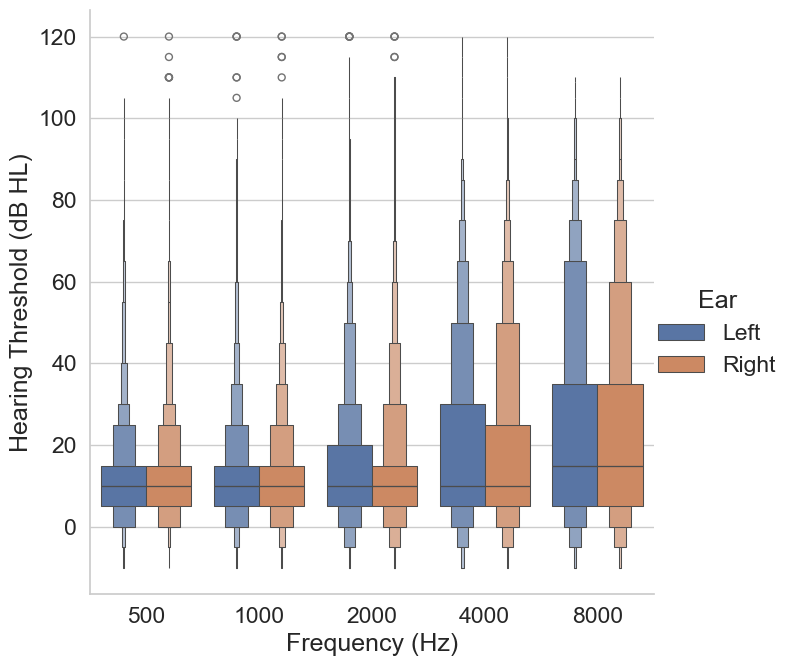

In [26]:
sns.catplot(
    data=ear_nhanes_pta, x="Frequency (Hz)", y="Hearing Threshold (dB HL)", hue="Ear",
    kind="boxen",
    errorbar=("pi", 95),
    #split=True,
    height=7
)

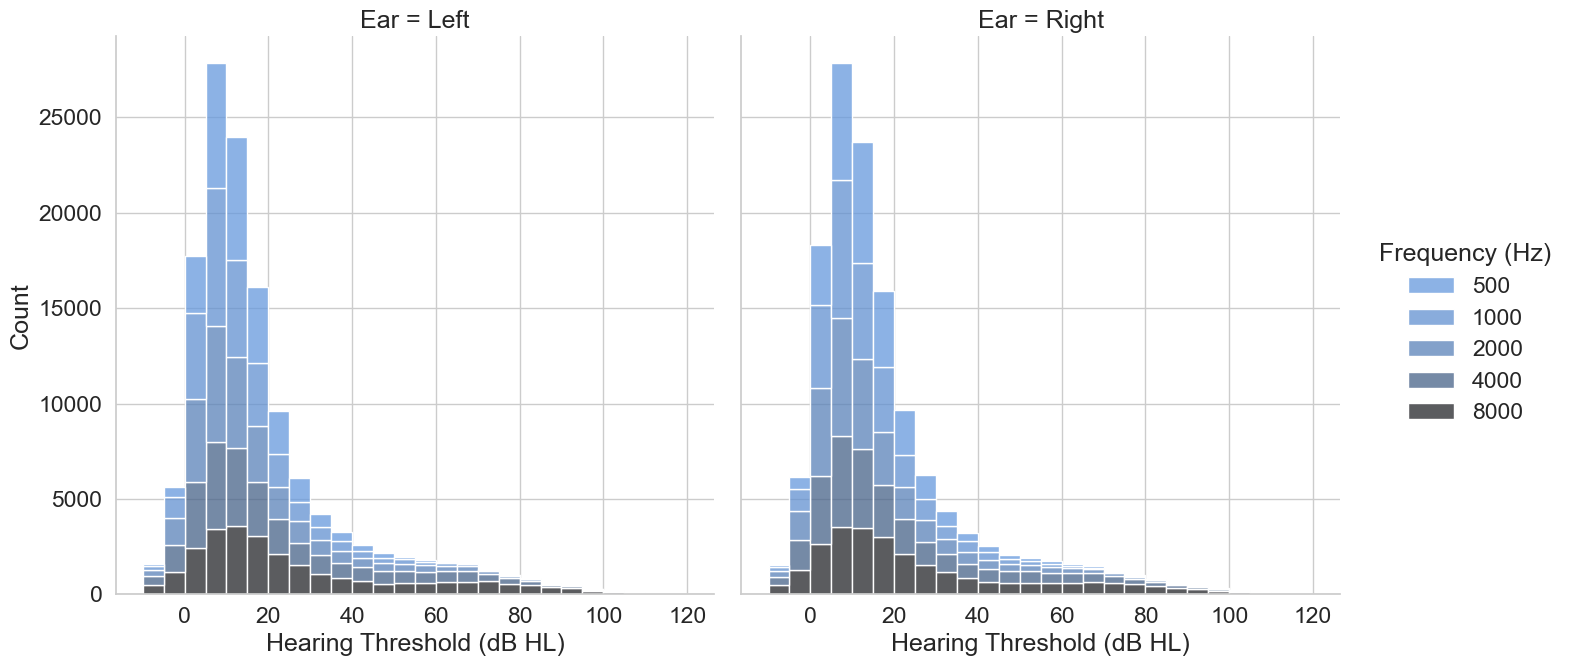

In [27]:
sns.displot(ear_nhanes_pta, x="Hearing Threshold (dB HL)", hue="Frequency (Hz)", col="Ear", multiple="stack",
            height=7, palette=sns.dark_palette("#69d", reverse=True, as_cmap=True),
            binwidth=5)

#### Distributions of thresholds of pure tones across age, Gender and Race

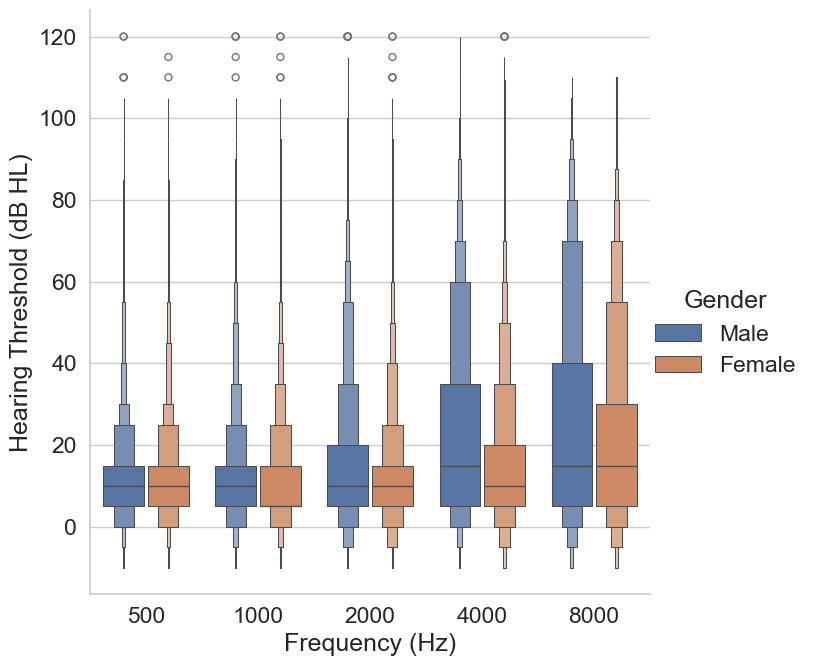

In [28]:
sns.catplot(
    data=nhanes_demo_pta_long_df, x="Frequency (Hz)", y="Hearing Threshold (dB HL)", hue="Gender",
    kind="boxen",
    errorbar=("pi", 95),
    #split=True,
    height=7,
    gap=0.1
)
plt.savefig('../figures/boxen_pta_gender_nhanes.png', dpi=300,  bbox_inches="tight")

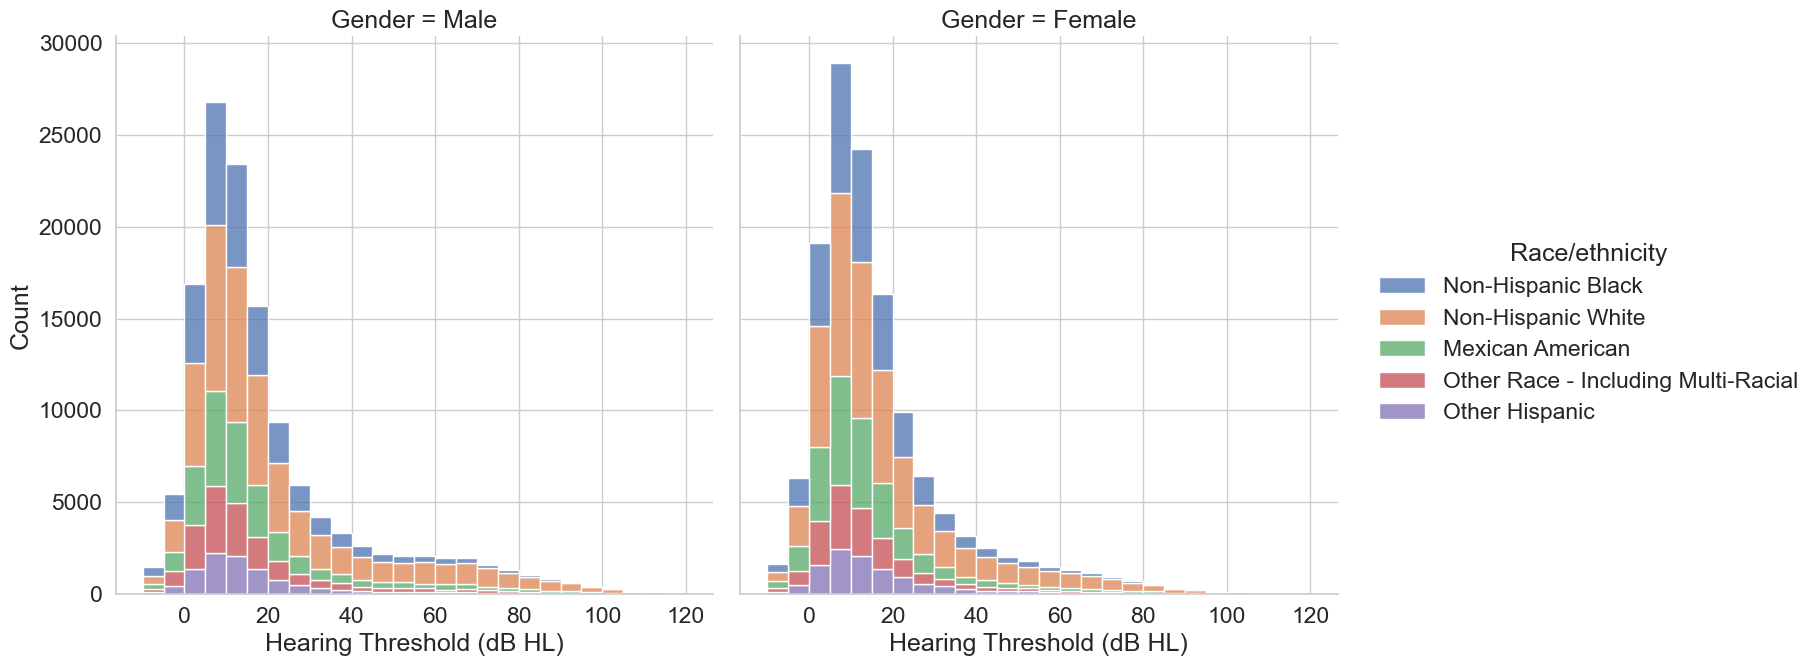

In [29]:
sns.displot(nhanes_demo_pta_long_df, x="Hearing Threshold (dB HL)", hue="Race/ethnicity", col="Gender", multiple="stack",
            height=7,
            binwidth=5)

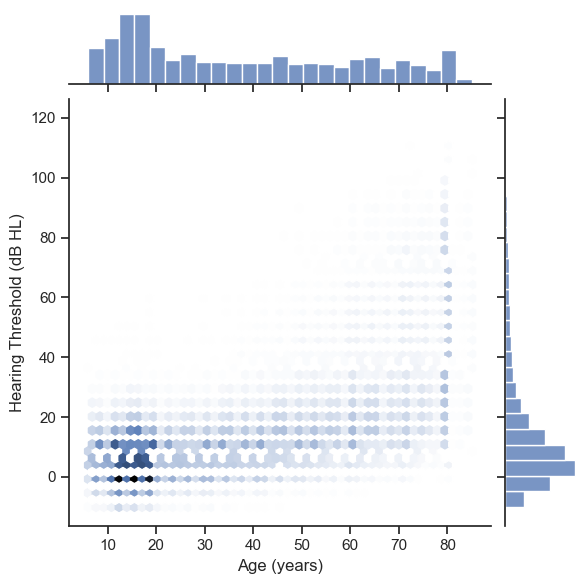

In [ ]:
sns.set_theme(style="ticks")

g = sns.jointplot(data=nhanes_demo_pta_long_df,
              x="Age (years)", y="Hearing Threshold (dB HL)",
              kind="hex",
              marginal_kws=dict(bins=25)
              )

plt.savefig('../figures/jointplot_age_hearingThreshold_nhanes.png', dpi=300,  bbox_inches="tight")

### Correlations

##### Correlation between pure tones thresholds | Split by Ear

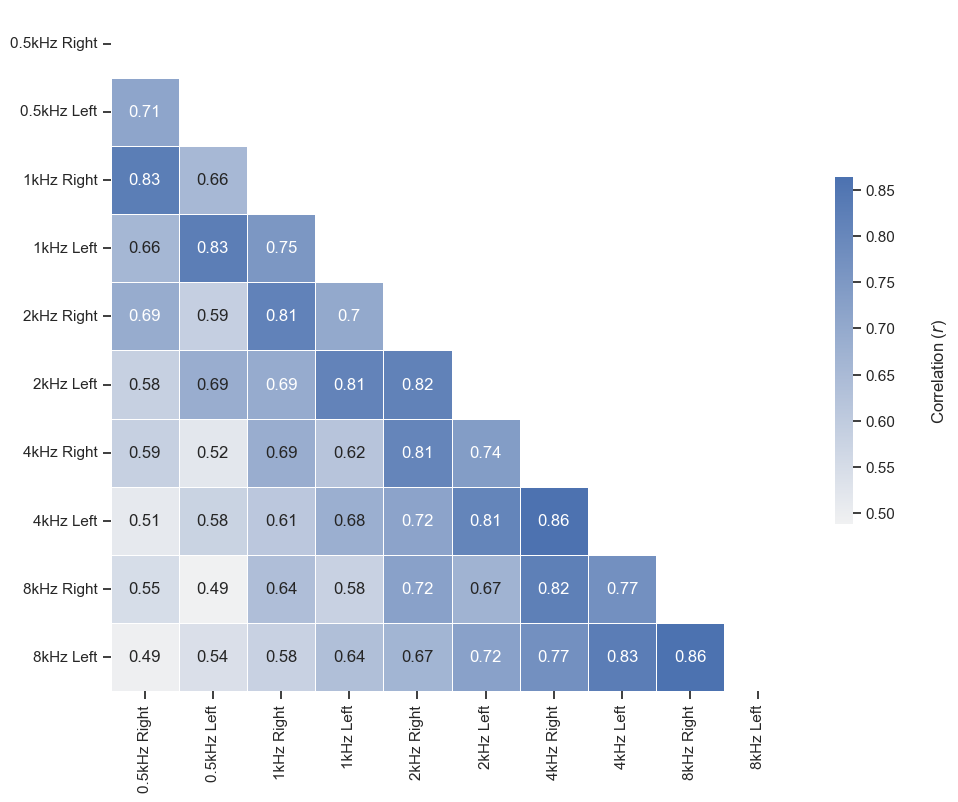

In [34]:
# Visualise correlations in hearing levels
# Compute the correlation matrix
corr = ordered_nhanes_pta.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# set style to remove gridlines
sns.set_style("white")

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,
            square=True, linewidths=0.5, cmap=sns.color_palette("light:b", as_cmap=True),
            annot=True,
            cbar_kws={"shrink": .5})

ax.text(12, 6, "Correlation ($r$)", rotation=90)
plt.savefig('../figures/corr_matrix_of_pta_nhanes.png', dpi=300,  bbox_inches="tight")

In [ ]:
rho = nhanes_demo_pta_for_corr.corr()
pval = nhanes_demo_pta_for_corr.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.05/12] if x<=t]))
rho.round(2).astype(str) + p

,0.5kHz Right,0.5kHz Left,1kHz Right,1kHz Left,2kHz Right,2kHz Left,4kHz Right,4kHz Left,8kHz Right,8kHz Left,RIAGENDR,Age (years),RIDRETH1
0.5kHz Right,1.0*,0.71*,0.83*,0.66*,0.69*,0.58*,0.59*,0.51*,0.55*,0.49*,0.02*,0.45*,-0.02*
0.5kHz Left,0.71*,1.0*,0.66*,0.83*,0.59*,0.69*,0.52*,0.58*,0.49*,0.54*,0.01,0.44*,-0.02*
1kHz Right,0.83*,0.66*,1.0*,0.75*,0.81*,0.69*,0.69*,0.61*,0.64*,0.58*,-0.03*,0.55*,-0.0
1kHz Left,0.66*,0.83*,0.75*,1.0*,0.7*,0.81*,0.62*,0.68*,0.58*,0.64*,-0.05*,0.54*,0.0
2kHz Right,0.69*,0.59*,0.81*,0.7*,1.0*,0.82*,0.81*,0.72*,0.72*,0.67*,-0.06*,0.62*,0.0
2kHz Left,0.58*,0.69*,0.69*,0.81*,0.82*,1.0*,0.74*,0.81*,0.67*,0.72*,-0.09*,0.61*,0.0
4kHz Right,0.59*,0.52*,0.69*,0.62*,0.81*,0.74*,1.0*,0.86*,0.82*,0.77*,-0.17*,0.71*,-0.03*
4kHz Left,0.51*,0.58*,0.61*,0.68*,0.72*,0.81*,0.86*,1.0*,0.77*,0.83*,-0.19*,0.72*,-0.03*
8kHz Right,0.55*,0.49*,0.64*,0.58*,0.72*,0.67*,0.82*,0.77*,1.0*,0.86*,-0.07*,0.76*,-0.01
8kHz Left,0.49*,0.54*,0.58*,0.64*,0.67*,0.72*,0.77*,0.83*,0.86*,1.0*,-0.08*,0.76*,0.0


##### Correlation between pure tones thresholds | Ear measures aggregated

In [21]:
rho = aggregated_df.corr()
pval = aggregated_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.05/12] if x<=t]))
rho.round(2).astype(str) + p

,0.5kHz,1kHz,2kHz,4kHz,8kHz,RIAGENDR,Age (years),RIDRETH1
0.5kHz,1.0*,0.85*,0.72*,0.61*,0.57*,0.02*,0.48*,-0.02*
1kHz,0.85*,1.0*,0.84*,0.72*,0.67*,-0.04*,0.58*,0.0
2kHz,0.72*,0.84*,1.0*,0.83*,0.75*,-0.08*,0.65*,0.0
4kHz,0.61*,0.72*,0.83*,1.0*,0.85*,-0.18*,0.74*,-0.03*
8kHz,0.57*,0.67*,0.75*,0.85*,1.0*,-0.07*,0.79*,-0.0
RIAGENDR,0.02*,-0.04*,-0.08*,-0.18*,-0.07*,1.0*,0.01,-0.02
Age (years),0.48*,0.58*,0.65*,0.74*,0.79*,0.01,1.0*,0.02*
RIDRETH1,-0.02*,0.0,0.0,-0.03*,-0.0,-0.02,0.02*,1.0*


In [22]:
# if wanted to create LaTeX table
#print(rho.to_latex(index = True, multirow = True, float_format="%.2f"))

### Audiogram curves

#### Aggregated audiogram curve across whole NHANES cohort

In [11]:
palette = ['#4c72b0', '#c44e52']
sns.set(font_scale=1.5, style="whitegrid")
sns.pointplot(data=nhanes_demo_pta_long_df,
                x="Frequency (Hz)",
                y="Hearing Threshold (dB HL)",
                hue="Ear",
                markers=["x", "o"],
                linestyles=["--", "--"],
                palette=palette,
                markersize=10,
                capsize=.1,
                errorbar=None,
                dodge=True)
sns.despine()
plt.xticks(np.arange(5))
plt.grid(visible=True, which='both')
plt.ylim((-10, 30))
plt.gca().invert_yaxis()
#plt.savefig('../figures/audiogram_curve_all_nhanes.png', dpi=300,  bbox_inches="tight")

TypeError: pointplot() got an unexpected keyword argument 'markersize'

### Audiogram curves of Whole, normal and hearing loss samples of NHANES

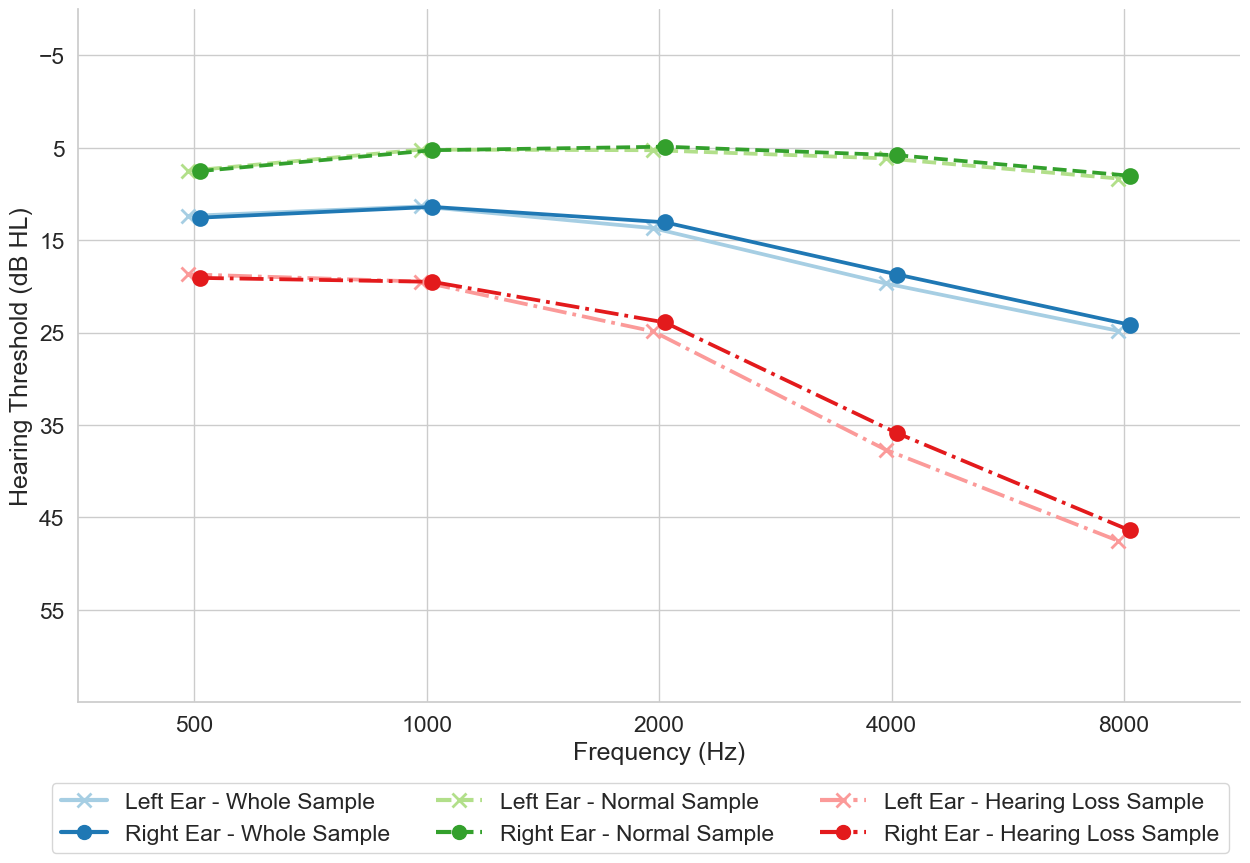

In [40]:
pal = sns.color_palette("Paired")

custom_lines = [Line2D([0], [0], color=pal[0], marker='x', linestyle='-', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[1], marker='o',linestyle='-', lw=3, markersize=10),
                Line2D([0], [0], color=pal[2], marker='x', linestyle='--', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[3], marker='o', linestyle='--', lw=3, markersize=10),
                Line2D([0], [0], color=pal[4], marker='x', linestyle='-.', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[5], marker='o', linestyle='-.', lw=3, markersize=10)]

sns.set(font_scale=1.5, style="whitegrid")
fig, ax = plt.subplots()

sns.pointplot(data=nhanes_demo_pta_long_df,
              ax=ax,
                x="Frequency (Hz)",
                y="Hearing Threshold (dB HL)",
                hue="Ear",
                markers=["x", "o"],
                linestyles=["-", "-"],
                palette=[pal[0], pal[1]],
                markersize=10,
                capsize=.1,
                errorbar=None,
                dodge=True,
                legend=True)

sns.pointplot(data=nhanes_demo_pta_HN_long_df,
              ax=ax,
                x="Frequency (Hz)",
                y="Hearing Threshold (dB HL)",
                hue="Ear",
                markers=["x", "o"],
                linestyles=["--", "--"],
                palette=[pal[2], pal[3]],
                markersize=10,
                capsize=.1,
                errorbar=None,
                dodge=True,
                legend=True)

sns.pointplot(data=nhanes_demo_pta_HL_long_df,
              ax=ax,
                x="Frequency (Hz)",
                y="Hearing Threshold (dB HL)",
                hue="Ear",
                markers=["x", "o"],
                linestyles=["-.", "-."],
                palette=[pal[4], pal[5]],
                markersize=10,
                capsize=.1,
                errorbar=None,
                dodge=True,
                legend=True)


plt.xticks(np.arange(5))
plt.yticks(np.arange(-5, 65, 10))
plt.grid(visible=True, which='both')
plt.ylim((-10, 65))
plt.gca().invert_yaxis()
ax.legend(custom_lines,
          ['Left Ear - Whole Sample',
           'Right Ear - Whole Sample',
           'Left Ear - Normal Sample',
           'Right Ear - Normal Sample',
           'Left Ear - Hearing Loss Sample',
           'Right Ear - Hearing Loss Sample',],
           ncols=3,
           loc='best', bbox_to_anchor=(1, -0.1))

sns.despine()
plt.savefig('../figures/audiogram_curve_all_hearingLoss_nhanes.png', dpi=300,  bbox_inches="tight")

In [15]:
nhanes_demo_pta_long_df

,SEQN,Hearing Threshold (dB HL),Frequency (Hz),Ear,Gender,Age (years),Race/ethnicity
0,10.0,10.0,500,Left,Male,43.0,Non-Hispanic Black
1,15.0,0.0,500,Left,Female,38.0,Non-Hispanic White
2,24.0,10.0,500,Left,Female,53.0,Non-Hispanic White
3,45.0,0.0,500,Left,Female,33.0,Mexican American
4,56.0,10.0,500,Left,Male,21.0,Non-Hispanic White
...,...,...,...,...,...,...,...
297135,124797.0,10.0,8000,Left,Male,9.0,Mexican American
297136,124799.0,NaN,8000,Left,Female,80.0,Non-Hispanic White
297137,124811.0,60.0,8000,Left,Male,76.0,Non-Hispanic White
297138,124820.0,15.0,8000,Left,Female,7.0,Non-Hispanic White


In [ ]:
# calculate standard deviation bands



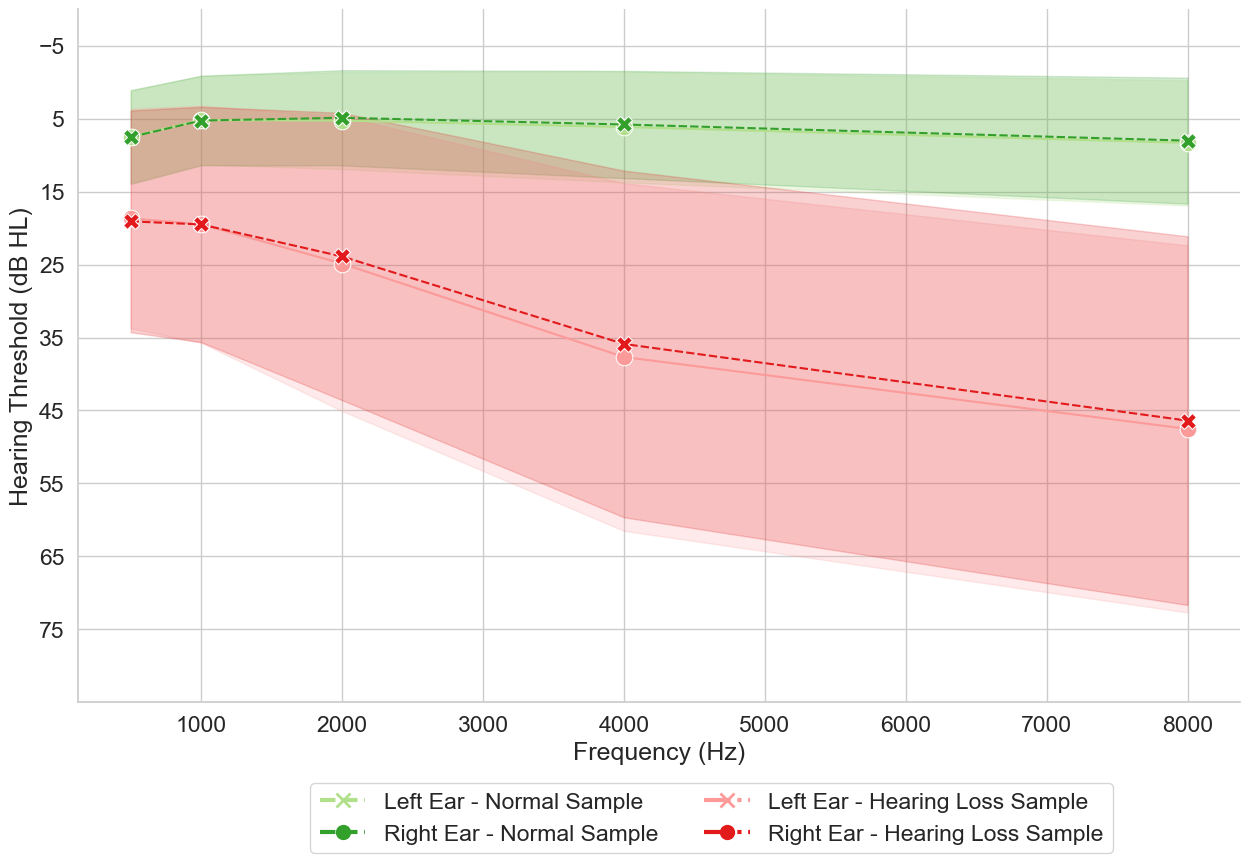

In [52]:
pal = sns.color_palette("Paired")

custom_lines = [Line2D([0], [0], color=pal[2], marker='x', linestyle='--', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[3], marker='o', linestyle='--', lw=3, markersize=10),
                Line2D([0], [0], color=pal[4], marker='x', linestyle='-.', lw=3, markersize=10, markeredgewidth=2),
                Line2D([0], [0], color=pal[5], marker='o', linestyle='-.', lw=3, markersize=10)]


sns.set(font_scale=1.5, style="whitegrid")
fig, ax = plt.subplots()

# Replace sns.pointplot with sns.lineplot and include the confidence interval
sns.lineplot(data=nhanes_demo_pta_HN_long_df,
             x="Frequency (Hz)",
             y="Hearing Threshold (dB HL)",
             hue="Ear",
             style="Ear",
             palette=[pal[2], pal[3]],
             markers=True,
             markersize=12,
             errorbar=('sd', 1),
             n_boot=1000,
             err_style='band',
             legend=True)  # Temporarily disable the legend

sns.lineplot(data=nhanes_demo_pta_HL_long_df,
             x="Frequency (Hz)",
             y="Hearing Threshold (dB HL)",
             hue="Ear",
             style="Ear",
             palette=[pal[4], pal[5]],
             markers=True,
             markersize=12,
             errorbar=('sd', 1),
             n_boot=1000,
             err_style='band',
             legend=True)  # Temporarily disable the legend

plt.yticks(np.arange(-5, 85, 10))
plt.grid(visible=True, which='both')
plt.ylim((-10, 85))
plt.gca().invert_yaxis()
ax.legend(custom_lines,
          ['Left Ear - Normal Sample',
           'Right Ear - Normal Sample',
           'Left Ear - Hearing Loss Sample',
           'Right Ear - Hearing Loss Sample',],
           ncols=2,
           loc='best', bbox_to_anchor=(0.9, -0.1))

sns.despine()
plt.savefig('../figures/audiogram_curve_errorBands_nhanes.png', dpi=300,  bbox_inches="tight")